100%|██████████| 89.6M/89.6M [00:00<00:00, 102MB/s] 


Extracting files...
Data source import complete.
Labels found: ['HerbaceousVegetation', 'SeaLake', 'Residential', 'Pasture', 'PermanentCrop', 'River', 'Forest', 'Highway', 'AnnualCrop', 'Industrial']


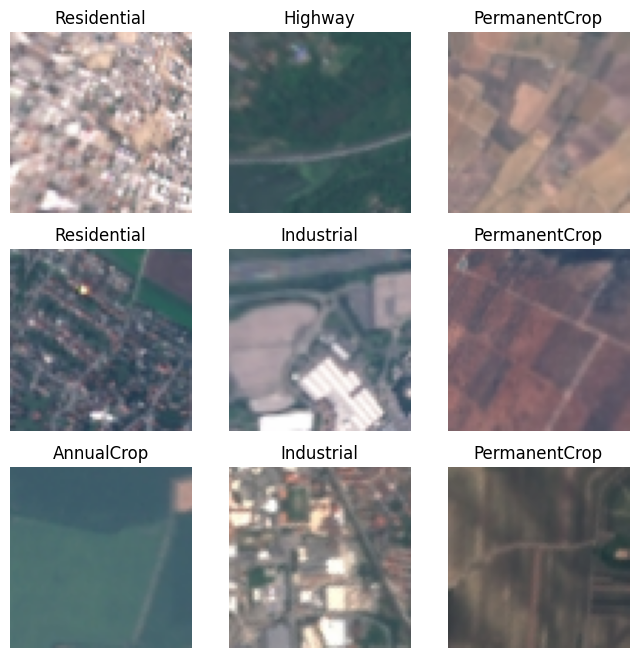

In [1]:
from fastai.vision.all import *
import kagglehub
import os

# Download the dataset using kagglehub
nilesh789_eurosat_rgb_path = kagglehub.dataset_download('nilesh789/eurosat-rgb')
DATASET = "/root/.cache/kagglehub/datasets/nilesh789/eurosat-rgb/versions/1/2750"

print('Data source import complete.')

# Define the labels based on the dataset directory structure
LABELS = os.listdir(DATASET)
print("Labels found:", LABELS)

# Path for training and validation directories
DATASET_PATH = Path(DATASET)

# Load the data using FastAI's ImageDataLoaders
dls = ImageDataLoaders.from_folder(
    DATASET_PATH,
    train='.',  # Since images are organized in label subfolders, use root directory
    valid_pct=0.2,  # Use 20% of the data for validation
    seed=42,  # Ensure reproducibility
    item_tfms=Resize(64),  # Resize images to 64x64
    batch_tfms=aug_transforms(
        do_flip=True,
        flip_vert=True,
        max_rotate=60.0,
        max_zoom=1.2,
        max_warp=0.2,
        max_lighting=0.2,
    ),
    bs=64  # Batch size
)

# Display some sample images
dls.show_batch(max_n=9, figsize=(8, 8))



In [ ]:
from google.colab import drive
from pathlib import Path  # Import the Path class

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory path and create it if it doesn't exist
SAVE_DIR = Path('/content/drive/MyDrive/models')  # Save to Google Drive or another persistent directory
SAVE_DIR.mkdir(parents=True, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the model using ResNet50
learn = cnn_learner(
    dls,
    resnet50,
    metrics=[accuracy, error_rate],
    pretrained=True  # Use pretrained weights from ImageNet
)

# Train the model with early stopping and learning rate adjustment
save_dir = '/content/drive/MyDrive/models'
learn.fit_one_cycle(
    7,  # Number of epochs
    lr_max=3e-3,  # Maximum learning rate
    cbs=[
        SaveModelCallback(monitor='accuracy', fname=f'{save_dir}/best_model'),
        EarlyStoppingCallback(monitor='accuracy', patience=3)
    ]
)

# Fine-tune the model



/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.901597,0.486845,0.845556,0.154444,21:21
1,0.474283,0.270150,0.912222,0.087778,21:04
2,0.344789,0.189258,0.935370,0.064630,20:59
3,0.253633,0.161332,0.946111,0.053889,20:56
4,0.220782,0.135687,0.953519,0.046481,20:50
5,0.180323,0.133171,0.952963,0.047037,20:58
6,0.169135,0.122091,0.956481,0.043519,21:09


Better model found at epoch 0 with accuracy value: 0.8455555438995361.
Better model found at epoch 1 with accuracy value: 0.9122222065925598.
Better model found at epoch 2 with accuracy value: 0.9353703856468201.
Better model found at epoch 3 with accuracy value: 0.9461110830307007.
Better model found at epoch 4 with accuracy value: 0.9535185098648071.
Better model found at epoch 6 with accuracy value: 0.9564814567565918.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [ ]:
save_dir = '/content/drive/MyDrive/models'
learn.unfreeze()
learn.fit_one_cycle(
    3,  # Additional epochs for fine-tuning
    lr_max=1e-4 , # Ld 2ower learning rate for fine-tuning
    cbs=[
        SaveModelCallback(monitor='accuracy', fname=f'{save_dir}/best_model_fine_tuned'),
        EarlyStoppingCallback(monitor='accuracy', patience=3)
    ]
)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.173202,0.132367,0.953148,0.046852,29:59
1,0.126500,0.102840,0.967407,0.032593,30:07
2,0.127665,0.098847,0.965556,0.034444,30:08


Better model found at epoch 0 with accuracy value: 0.9531481266021729.
Better model found at epoch 1 with accuracy value: 0.9674074053764343.


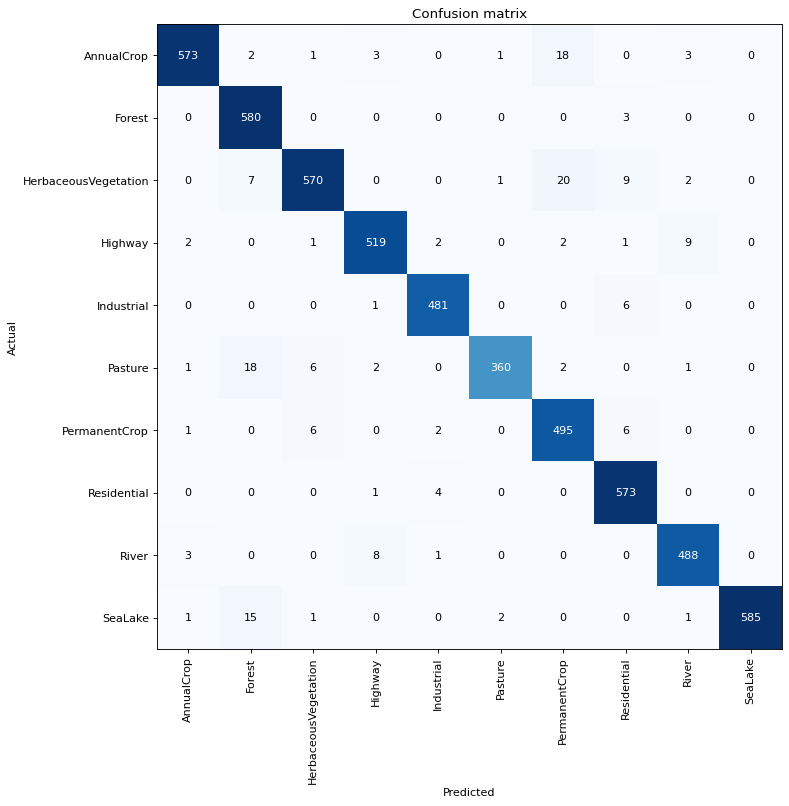

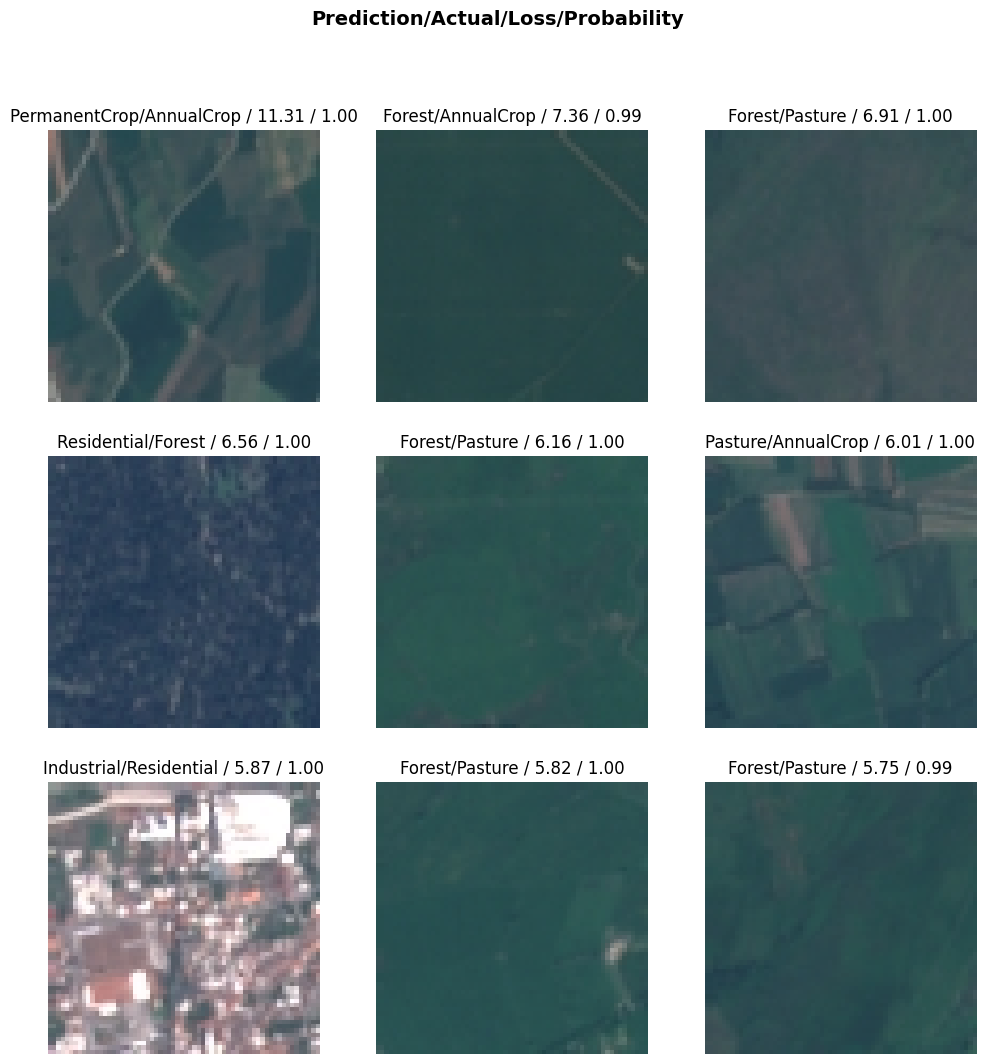

In [ ]:
# Evaluate the model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=80)
interp.plot_top_losses(9, figsize=(12, 12))

# Save the model
learn.export('resnet50_fastai.pkl')



In [4]:
from fastai.vision.all import *
from pathlib import Path

# Define paths
LOAD_PATH = Path('/content/drive/MyDrive/models')
MODEL_NAME = 'best_model_fine_tuned'

# Recreate the DataLoaders (ensure this matches the original training setup)
dls = ImageDataLoaders.from_folder(
    DATASET_PATH,  # Define DATASET_PATH to point to your dataset directory
    train='.',
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(64),
    batch_tfms=aug_transforms(),
    bs=64
)

# Recreate the learner
learn = cnn_learner(dls, resnet50, metrics=[accuracy, error_rate])

# Load the weights
learn.load(LOAD_PATH / MODEL_NAME)
print("Model weights loaded successfully!")


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 95.5MB/s]
/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbi

Model weights loaded successfully!


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:61: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


In [5]:
from pathlib import Path

# Verify the folder structure
DATASET_PATH = Path(DATASET)
for item in DATASET_PATH.iterdir():
    print(item.name, "->", "Directory" if item.is_dir() else "File")


HerbaceousVegetation -> Directory
SeaLake -> Directory
Residential -> Directory
models -> Directory
Pasture -> Directory
PermanentCrop -> Directory
River -> Directory
Forest -> Directory
Highway -> Directory
AnnualCrop -> Directory
Industrial -> Directory


In [10]:
import shutil
from random import sample

# Create a test directory
test_path = DATASET_PATH / "test"
test_path.mkdir(exist_ok=True)

# Sample 10 images from each class to create the test set
for class_folder in DATASET_PATH.iterdir():
    if class_folder.is_dir() and class_folder.name != "test":
        test_class_path = test_path / class_folder.name
        test_class_path.mkdir(exist_ok=True)

        # Randomly select 10 images from the class folder
        class_images = list(class_folder.glob("*.jpg"))  # Update extension if needed
        sampled_images = sample(class_images, min(10, len(class_images)))  # At most 10 images
        for img in sampled_images:
            shutil.move(str(img), str(test_class_path))

print("Test folder created with the following structure:")
for item in test_path.iterdir():
    print(item.name, "->", len(list(item.glob("*"))), "files")


Test folder created with the following structure:
HerbaceousVegetation -> 10 files
SeaLake -> 10 files
Residential -> 10 files
models -> 0 files
Pasture -> 10 files
PermanentCrop -> 10 files
River -> 10 files
Forest -> 10 files
Highway -> 10 files
AnnualCrop -> 10 files
Industrial -> 10 files


In [8]:
import random
from pathlib import Path

# Path to the test directory
test_path = DATASET_PATH / "test"

# Gather all images from all class folders
all_images = []
for class_folder in test_path.iterdir():
    if class_folder.is_dir():
        all_images.extend(list(class_folder.glob("*.jpg")))  # Update extension if needed

# Shuffle the collected images
random.shuffle(all_images)

# Clear out the test folder structure
for class_folder in test_path.iterdir():
    if class_folder.is_dir():
        for img in class_folder.glob("*.jpg"):
            img.unlink()  # Remove existing images in class folders

# Redistribute the shuffled images into class folders
class_folders = list(test_path.iterdir())
for idx, img in enumerate(all_images):
    if img.exists():  # Check if the file still exists
        target_class_folder = class_folders[idx % len(class_folders)]
        img.rename(target_class_folder / img.name)  # Move the image to a shuffled folder
    else:
        print(f"File not found: {img}, skipping.")

print("Test folder images shuffled successfully!")


Test folder images shuffled successfully!


In [12]:
dls = ImageDataLoaders.from_folder(
    DATASET_PATH,
    train='.',  # Since images are organized in label subfolders, use root directory
    valid_pct=0.2,  # Use 20% of the data for validation
    seed=42,  # Ensure reproducibility
    item_tfms=Resize(64),  # Resize images to 64x64
    batch_tfms=aug_transforms(
        do_flip=True,
        flip_vert=True,
        max_rotate=60.0,
        max_zoom=1.2,
        max_warp=0.2,
        max_lighting=0.2,
    ),
    bs=64  # Batch size
)

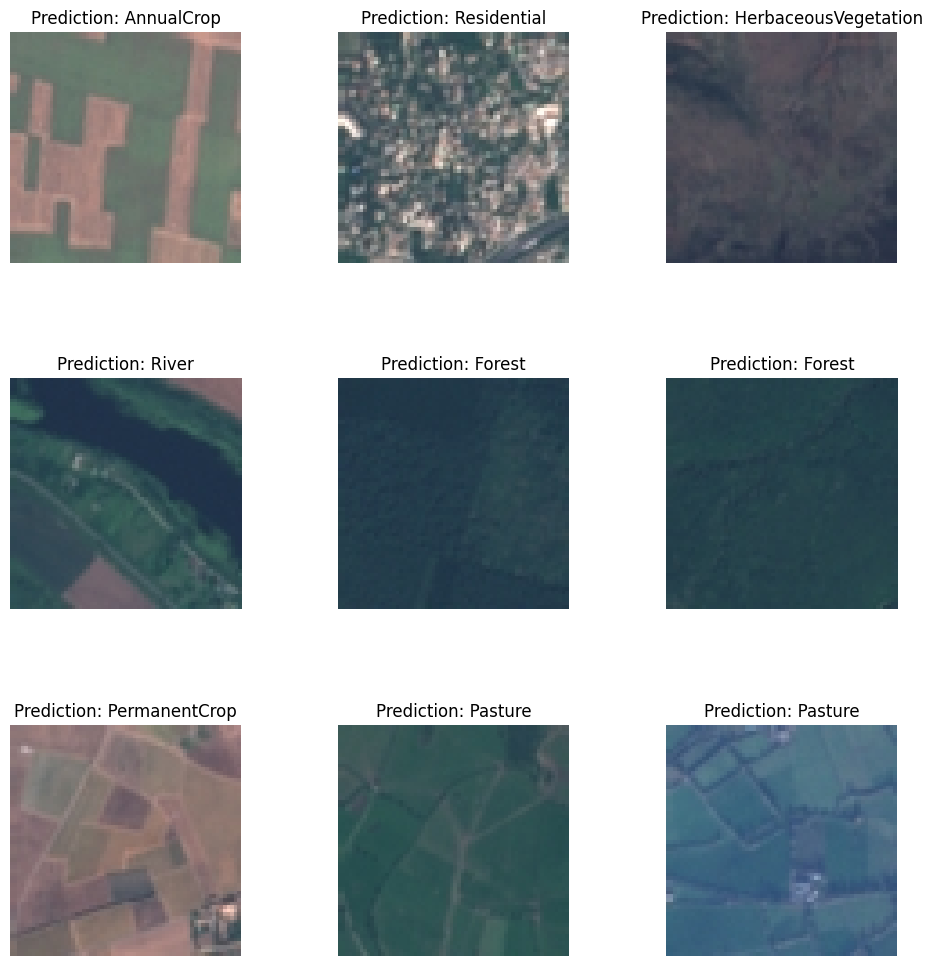

In [19]:
from fastai.vision.all import *
from matplotlib import pyplot as plt
from random import sample

# Randomly select up to 9 images from the test folder
random_test_images = sample(test_images, min(9, len(test_images)))

# Create a test DataLoader for the selected random images
random_test_dl = learn.dls.test_dl(random_test_images, with_labels=False)

# Get predictions for the random test images
preds, _ = learn.get_preds(dl=random_test_dl)

# Decode predictions to class names
decoded_preds = [learn.dls.vocab[p.argmax().item()] for p in preds]

# Plot images in a grid with predictions
n_cols = 3  # Number of columns in the grid
n_rows = -(-len(random_test_images) // n_cols)  # Calculate rows based on the number of images

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)  # Add space between rows

for ax, img_path, pred in zip(axs.flatten(), random_test_images, decoded_preds):
    img = PILImage.create(img_path)
    ax.imshow(img)
    ax.set_title(f"Prediction: {pred}")
    ax.axis('off')

# Hide any extra subplots
for ax in axs.flatten()[len(random_test_images):]:
    ax.axis('off')

plt.show()
